In [1]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import os
import math
import numpy as np
import pandas as pd
import pickle
#import blaze as bz
import pyspark as py
from time import time
from collections import Counter
import statsmodels as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
from scipy.sparse import csc_matrix
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import RDD
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameReader
from pyspark.sql import DataFrameWriter
from pyspark.sql import types
from pyspark.sql.types import StructType, IntegerType, StringType, DecimalType
from pyspark.sql import DataFrameNaFunctions, \
DataFrameStatFunctions as statFunc
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.mllib.clustering import LDA
from sklearn import preprocessing 
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.classification import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
#import mongodb.jdbc.MongoDriver

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error


import matplotlib.pyplot as plt
import seaborn as sb

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel, LabelSet
from bokeh.transform import factor_cmap, jitter
from bokeh.palettes import Paired12, Spectral6, Viridis3

output_notebook()

C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Loading BokehJS ...

In [2]:
#os.environ["CLASSPATH"]
#os.environ['PYSPARK_SUBMIT_ARGS'] = "--master=local[3] pyspark-shell"
os.environ['JAVA_HOME'] = "C:\\Program Files\\Java\\jdk1.8.0_191"

In [3]:
conf = SparkConf().set("spark.home", "C:\\MathLabASUS\\SW\\DM\\spark-2.4.0-bin-hadoop2.7") \
.set("spark.driver.extraClasspath", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1") \
.set("spark.driver.extraClasspath", "org.mongodb:mongo-java-driver:3.9.0") \
.set("spark.submit.deployMode", "client") \
.set("spark.driver.memory", "2G") \
.set("spark.driver.maxResultSize", "2G") \
#.set("spark.mongodb.input.uri", "mongodb://127.0.0.1/ryerson.ferguson24?readPreference=primaryPreferred") \
#.set("spark.mongodb.output.uri", "mongodb://127.0.0.1/ryerson.ferguson24") 

In [4]:
sc = py.SparkContext("local[1]", conf=conf)

sc.stop()

In [5]:
sqlContext = SQLContext(sc)

s1 =SparkSession.builder.config(conf=SparkConf())
sc.getConf()

In [6]:
os.getcwd()

'c:\\MathLabASUS\\Projects\\Kaggle\\AirBnB\\airbnb_kaggle'

In [7]:
session_df = sqlContext.read.csv("sessions.csv", \
                    header = True, mode = "DROPMALFORMED")

In [8]:
### Fill in missing values for categorical and numerical columns

In [9]:
session_df[["action", "action_type", "action_detail", "device_type"]].fillna("None")

DataFrame[action: string, action_type: string, action_detail: string, device_type: string]

In [10]:
##### Save session as a spark table

In [11]:
session_df.registerTempTable("session_df")

In [12]:
#### Define user actions in a session

In [13]:
%%time
action_df = sqlContext.sql("SELECT action, AVG(secs_elapsed) AS mean_secs FROM \
            session_df \
            GROUP BY action \
          ")
action_df = action_df.withColumn("mean_mins", col("mean_secs")/float(60.0))

Wall time: 294 ms


In [14]:
##### Distribution of time spent in minutes in an airbnb session

In [15]:
hist, edges = np.histogram(action_df.toPandas()["mean_mins"], density = True, \
                           bins = "auto")

In [16]:
output_notebook()
#bokeh.io.output_notebook()

session_data = ColumnDataSource(data = action_df.toPandas())
plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)
plot.quad(bottom=0, top = hist, left = edges[:-1], \
          right = edges[1:], \
          fill_color = "blue", line_color = "white", alpha = 0.8, \
         hover_fill_color = "green")
plot.title.text = 'Distribution of time spent on airbnb (in a session)'
plot.xaxis.axis_label = 'Average time (minutes)'
plot.yaxis.axis_label = 'Frequency'
#plot.xaxis.major_label_orientation = 90
hover = HoverTool(tooltips = [('Frequency', '@{Frequency}{,}'), \
                              ('Average time (minutes)', '@hist'), ]) #('Frequency', '@Frequency')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

Most user actions on the website take less than 5,000 minutes. In fact anything above 
3,000 might be considered an outlier. Most users probably leave the 
web browser open while engaging in other activities. Time spent in 
minutes does not seem useful at this stage.

In [ ]:
#### Top 20 user actions in a session - time spent in minutes

In [18]:
action_df[["action", "mean_mins"]].sort(desc("mean_mins")).toPandas().head(10)

,action,mean_mins
0,new_session,17526.916667
1,locations,13461.991667
2,recommend,8635.666667
3,10,6789.599218
4,12,6642.852737
5,set_password,5947.009748
6,payoneer_signup_complete,5218.083333
7,press_news,5055.350000
8,life,4913.033333
9,ajax_send_message,4829.912500


The time spent in by a user on a specific action appears to contain ouliers. Verify using some basic descriptive statisy=tics.

In [19]:
### Descriptive statistics

In [20]:
##### Get mean, median and total values of time spent in a sesion (secs_elapsed)

In [21]:
session_df = session_df.withColumn("secs_elapsed", session_df["secs_elapsed"].cast(IntegerType()))

In [22]:
print("Mean time spent in user session = {}" .format(np.round(session_df.select("secs_elapsed").agg(avg(col("secs_elapsed"))).take(1)[0]["avg(secs_elapsed)"])))
print("Median time spent in user session = {}" .format(np.round(session_df.approxQuantile("secs_elapsed", [0.5], 0)[0])))

Mean time spent in user session = 21593.0
Median time spent in user session = 1314.0


The mean >> median. This implies that there are some large values 
(outliers) in the amount of time a user spends in a session. 

In [23]:
##### Remove ouliers

In [24]:
quantiles = action_df.toPandas().quantile([0.25, 0.75]).reset_index()
outlier_cutoff = quantiles.loc[1]["mean_mins"] + (1.5 * (quantiles.loc[1]["mean_mins"] - \
                                                    quantiles.loc[0]["mean_mins"]))

In [25]:
quantiles 

,index,mean_secs,mean_mins
0,0.25,12169.734148,202.828902
1,0.75,73306.333333,1221.772222


In [26]:
outlier_cutoff

2750.1872018452887

In [27]:
##### Top 10 actions by AirBnB users - ouliers removed

In [28]:
%%time
action_df_no_outliers = action_df.filter(col("mean_mins") <= \
                                         outlier_cutoff).sort(desc("mean_mins"))
action_df_no_outliers_top10 = sqlContext.createDataFrame(action_df_no_outliers.head(10))

Wall time: 9.98 s


In [29]:
action_pd_df_10 = action_df_no_outliers.sort(desc("mean_mins")).toPandas()
action_pd_df_10["mean_mins"] = np.round(action_pd_df_10["mean_mins"])#[["action", "mean_mins"]]
action_pd_df_10[["action", "mean_mins"]].head(10)

,action,mean_mins
0,guest_booked_elsewhere,2629.0
1,salute,2593.0
2,concierge,2547.0
3,email_itinerary_colorbox,2439.0
4,upload,2361.0
5,receipt,2197.0
6,mobile_landing_page,2172.0
7,cancellation_policies,2156.0
8,other_hosting_reviews,2152.0
9,press_release,2080.0


In [30]:
#### Get more details on user actions in a session

In [31]:
##### Calculate the average time spent during specific users action

In [32]:
session_group = Window().partitionBy("action", "action_type", "action_detail")
#median_udf = udf(lambda x: int(np.nanmedian(x)), IntegerType())
session_df = session_df.withColumn("secs_elapsed", \
                                   when(col("secs_elapsed").isNull(), \
                                        count(col("secs_elapsed")).over(session_group)).otherwise(col("secs_elapsed"))) 

In [33]:
##### Plot detailed user actions with outliers removed

In [34]:
### Find and plot top 10 user activities (action, type, and detail) by count and average minutes

In [35]:
%%time
user_activity_df = sqlContext.sql("SELECT action, action_type, \
                        action_detail, \
                        COUNT(action, action_type, action_detail) as count, \
                        PERCENTILE_APPROX(secs_elapsed, 0.5) AS avg_secs, \
                        PERCENTILE_APPROX(secs_elapsed, 0.5)/60 AS avg_mins \
                        FROM session_df \
                        GROUP BY action, action_type, action_detail \
          ")

Wall time: 156 ms


In [36]:
user_activity_df = user_activity_df.withColumn("activity", concat(lit("["), col("action"), lit(", "), col("action_type"), lit(", "), col("action_detail"), lit("]")))

In [37]:
user_activity_df.select("activity", "count", \
                        "avg_mins").filter(col("count") >= 50).distinct().sort(desc("avg_mins")).toPandas().head(10) #.dropDuplicates(["activity", "mean_mins"]).collect()

,activity,count,avg_mins
0,"[recommend, -unknown-, -unknown-]",73,7027.333333
1,"[10, message_post, message_post]",213,4166.666667
2,"[12, message_post, message_post]",274,3531.033333
3,"[set_password, submit, set_password]",54,3222.466667
4,"[jumio_redirect, -unknown-, -unknown-]",450,2073.266667
5,"[this_hosting_reviews, click, listing_reviews_...",773,1317.350000
6,"[other_hosting_reviews, -unknown-, -unknown-]",115,1260.333333
7,"[languages_multiselect, -unknown-, -unknown-]",653,1252.150000
8,"[create, submit, create_phone_numbers]",4369,1118.400000
9,"[11, message_post, message_post]",50,1003.450000


There are still some large values for the average amount of time a user
spends in a session. Sort user sessions by count instead.

In [38]:
##### Sort top 10 user activities by count

In [39]:
user_activity_pd_df = user_activity_df.select("activity", "count", "avg_mins").distinct().sort(desc("count")).toPandas() #.dropDuplicates(["activity", "mean_mins"]).collect()

In [40]:
user_activity_pd_df = user_activity_df.toPandas().sort_values("count", ascending = False)
user_activity_pd_df["avg_mins"] = np.round(user_activity_pd_df["avg_mins"])
user_activity_pd_df[["activity", "count", "avg_mins"]].head(10)

,activity,count,avg_mins
121,"[search_results, click, view_search_results]",106030,88.0
97,"[personalize, data, wishlist_content_update]",104103,17.0
208,"[show, view, p3]",96191,192.0
234,"[ajax_refresh_subtotal, click, change_trip_cha...",70506,14.0
99,"[similar_listings, data, similar_listings]",52997,3.0
283,"[index, view, view_search_results]",40652,320.0
74,"[update, submit, update_listing]",28934,189.0
37,"[show, view, user_profile]",24141,8.0
51,"[search, click, view_search_results]",22282,34.0
200,"[header_userpic, data, header_userpic]",16998,19.0


In [41]:
### Analyze train_user2 data

In [42]:
train_user_df = sqlContext.read.csv("train_users_2.csv", \
                    header = True, mode = "DROPMALFORMED")

In [43]:
train_user_df.count()

213451

In [44]:
train_user_df.toPandas().columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [45]:
#### Get an idea about age distribution before replacing null values

In [46]:
age_list = [val[0] for val in train_user_df.select(col("age")).collect()]

In [47]:
age_pd_df = pd.DataFrame(age_list, columns = ["age"])

In [48]:
age_pd_df.count()

age    125461
dtype: int64

In [49]:
#### Basic statistics about age

In [50]:
age_pd_df.dropna(subset = ["age"], inplace = True)

In [51]:
age_hist = age_pd_df.groupby("age").size().reset_index(name = "count")
age_hist["age"] = age_hist["age"].astype(int)
age_hist["age"].describe()

count     127.000000
mean      375.448819
std       704.056328
min         1.000000
25%        42.500000
50%        74.000000
75%       105.500000
max      2014.000000
Name: age, dtype: float64

In [52]:
#output_notebook()
output_notebook()

session_data = ColumnDataSource(data = age_hist)

age = session_data.data['age'].tolist()
#color_map = factor_cmap(field_name='age', palette=Paired12, \
 #                       factors = age)

plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)

plot.vbar(x = "age", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = 'Age distribution of AiBnB customers'
plot.xaxis.axis_label = 'Age'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Age', '@age'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

Some incorrect values for age 105 and over. Remove these errors or ouliers

In [53]:
age_hist = age_hist[age_hist["age"] < 105]

In [54]:
#output_notebook()
output_notebook()

session_data = ColumnDataSource(data = age_hist)

plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)

plot.vbar(x = "age", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = 'Age distribution of AirBnB customers'
plot.xaxis.axis_label = 'Age'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Age', '@age'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

Most AirBnB customers range in age from 18 to 70

In [55]:
##### Replace missing values

In [56]:
train_user_df = train_user_df.fillna({"date_first_booking": "-unknown-", \
                                       "gender": "-unknown-", "age": \
                                       train_user_df.filter(train_user_df["age"] \
                                                            < 105).agg(avg(col("age"))).take(1)[0]["avg(age)"], \
                      "first_affiliate_tracked": "-unknown-"})

In [57]:
#### Convert date columns to date types

In [58]:
train_user_df = train_user_df.withColumn("date_account_created", to_date("date_account_created", "yyyy-MM-dd"))
train_user_df = train_user_df.withColumn("date_first_booking", to_date("date_first_booking", "yyyy-MM-dd"))

In [59]:
train_user_df = train_user_df.withColumn("timestamp_first_active", to_timestamp(train_user_df.timestamp_first_active, "yyyyMMddhhmmss")).alias("timestamp_first_active")

In [60]:
train_user_df.registerTempTable("train_user_df")

In [61]:
##### Convert spark dataframe to pandas dataframe

In [62]:
train_user_pd_df = train_user_df.toPandas()

In [63]:
#### Placeholder to save train_user_pd_df dataframe

train_user_pd_df.to_csv("train_user_pd_df.csv", index = False)

##### Read the train_user pandas dataaframe file from csv

train_user_pd_df = pd.read_csv("train_user_pd_df.csv")

In [64]:
#### End of placehoder

In [65]:
##### Create column for no. of days before first booking

In [66]:
train_user_pd_df["date_account_created"] = pd.to_datetime(train_user_pd_df["date_account_created"])
train_user_pd_df["date_first_booking"] = pd.to_datetime(train_user_pd_df["date_first_booking"])

In [67]:
train_user_pd_df["days_first_booking"] = (train_user_pd_df["date_first_booking"] - train_user_pd_df["date_account_created"]).dt.days

In [68]:
train_user_pd_df[train_user_pd_df["days_first_booking"] < 0]["days_first_booking"].count()

29

Days before first booking has around 29 erroneous values, i.e. 
no. of days < 0. If used in a model need to remove these rows.

In [ ]:
##### Fill in missing values and round age to integer

In [70]:
train_user_pd_df[["timestamp_first_active", "date_first_booking", "days_first_booking"]] = train_user_pd_df[["timestamp_first_active", "date_first_booking", "days_first_booking"]].fillna("-unknown-")

In [71]:
train_user_pd_df["age"] = np.ceil(train_user_pd_df["age"].astype("float").head()).astype("int")

In [72]:
#### Visualization of other variables

In [73]:
gender_by_signup_method = train_user_pd_df.set_index("gender", "signup_method").groupby(["gender", \
                                                                                         "signup_method"], as_index = False).size().reset_index(name = "size")#.fillna(0).reset_index(name = "size")

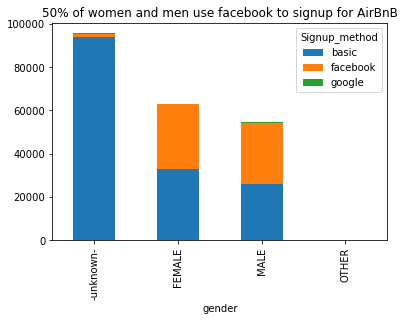

In [75]:
source_ct = pd.crosstab(gender_by_signup_method["gender"], gender_by_signup_method["signup_method"])
source_pt = gender_by_signup_method.pivot(index = "gender", \
                                    columns = "signup_method", \
                                   values = "size")
source_pt.plot.bar(stacked = True)
plt.title(label = "50% of women and men use facebook to signup for AirBnB")
plt.legend(title = "Signup_method")

Approx. 50% of women and men use facebook to signup for AirBnB.
Correlation ratio (wrt days_first_booking) = 0.38

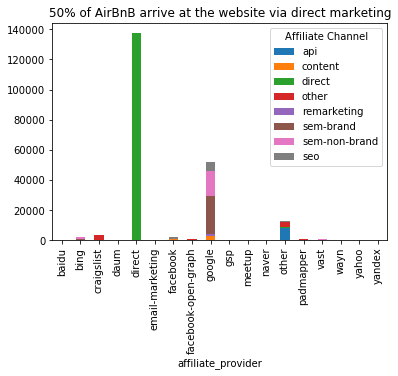

In [78]:
affiliate_provider_channel = train_user_pd_df.groupby(["affiliate_provider", \
                                                   "affiliate_channel"]).size().reset_index(name = "size")

affiliate_ct = pd.crosstab(affiliate_provider_channel["affiliate_provider"], affiliate_provider_channel["affiliate_channel"])
affiliate_pt = affiliate_provider_channel.pivot(index = "affiliate_provider", \
                                    columns = "affiliate_channel", \
                                   values = "size")
affiliate_pt.plot.bar(stacked = True)
plt.title(label = "50% of AirBnB arrive at the website via direct marketing")
plt.legend(title = "Affiliate Channel")

Just undr 50% of customers use direct marketing providers and channels.
Correlation ratio (wrt days_first_booking) = 0.62

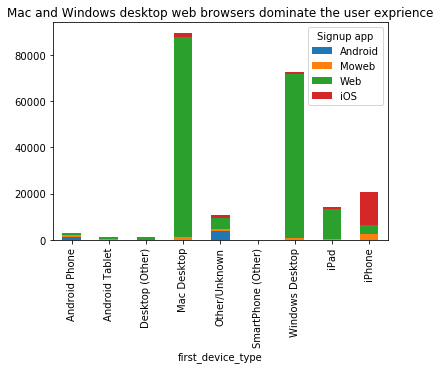

In [79]:
device_type_signupapp = train_user_pd_df.groupby(["first_device_type", \
                                                   "signup_app"]).size().reset_index(name = "size")

deviceapp_ct = pd.crosstab(device_type_signupapp["first_device_type"], device_type_signupapp["signup_app"])
deviceapp_pt = device_type_signupapp.pivot(index = "first_device_type", \
                                    columns = "signup_app", \
                                   values = "size")
deviceapp_pt.plot.bar(stacked = True)
plt.title(label = "Mac and Windows desktop web browsers dominate the user exprience")
plt.legend(title = "Signup app", \
           loc = "upper right")

Most customers use Mac and Windows Desktop users with their browser followed by iPad 
(browser) and iPhone (iOS).
Correlation ratio (wrt days_first_booking) = 0.55

In [ ]:
#############################################################

In [ ]:
############# Start of Imputation code ######################

In [ ]:
### Distribution of number of days until first booking

Deal with missing values or unknowns. The columns conataining missing 
values are: gender, age, first_affiliate_tracked, first_browser, 
    date_first_booking

In [ ]:
#########################################################################################

In [ ]:
### Replace missing values using KNN

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

Deal with missing values or unknowns. The columns conataining missing 
values are: gender, age, first_affiliate_tracked, first_browser, date_first_booking

In [83]:
train_user_pd_df_nan = pd.read_csv("train_users_2.csv")
train_user_pd_df_nan.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [ ]:
##### Add a variable for avg time a user spends in a session before booking

AirBnB customers apppear to have their browsers open for long periods (large timeout values). 
The session timeout values for AirBnB can  also be set to large values.
Action popularity might be a more useful metric/variable.

In [108]:
train_user_pd_df_nan = pd.read_csv("train_users_2.csv")
age_df = train_user_pd_df_nan[["age"]]
 
'''
train_user_pd_df_nan[(train_user_pd_df_nan["age"] >= 18) &  
                               (train_user_pd_df_nan["age"] <= 105) |
                             (train_user_pd_df_nan["age"] == np.nan)]["age"]
'''

train_user_pd_df_nan = train_user_pd_df_nan.drop(train_user_pd_df_nan.columns[[0, 5]], \
                                           axis = 1, inplace = False)
train_user_pd_df_nan["days_first_booking"] = (np.abs(pd.to_datetime(train_user_pd_df_nan["date_account_created"]) - pd.to_datetime(train_user_pd_df_nan["date_first_booking"])).dt.days)
#X[(X["days_first_booking"] >= 0)]["days_first_booking"].count()
train_user_pd_df_nan["days_first_booking"].replace(train_user_pd_df_nan[(train_user_pd_df_nan["days_first_booking"] < 0)], np.sin(train_user_pd_df_nan["days_first_booking"]), inplace = True)
train_user_pd_df_nan.replace(["-unknown-", np.nan], 10000, inplace = True)
days_df = train_user_pd_df_nan[["days_first_booking"]].astype(int)
train_user_pd_df_nan = train_user_pd_df_nan.iloc[:, 3:-1]

Check missing values - blank, NaNs, different ranges

In [281]:
train_user_pd_df_nan.columns

Index(['gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination'],
      dtype='object')

In [111]:
X_imp = train_user_pd_df_nan

In [110]:
X_imp.head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,10000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,MALE,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,FEMALE,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,FEMALE,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,10000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
### Encode strings as integers

In [112]:
X_imp.replace([np.nan, np.inf], 10000, inplace = True)

In [113]:
X_imp = X_imp.astype(str)

In [114]:
cat_columns =["gender", "signup_method", \
              "signup_flow", 
              "language", \
              "affiliate_channel", 
              "affiliate_provider", \
              "first_affiliate_tracked", \
              "signup_app", "first_device_type", "first_browser", \
              "country_destination"]

In [115]:
from sklearn import preprocessing

In [116]:
labels_lst = []
le = LabelEncoder()
for col in X_imp.columns:
    le_array = le.fit_transform(X_imp[col])
    labels_lst.append(le_array)
    labels_np = np.transpose(np.array(labels_lst))

labels_df = pd.DataFrame(labels_np, columns = X_imp.columns).reset_index()
#labels_df.replace(0, 10000, inplace = True)

##### Verify thay all NaNs have been removed

np.isfinite(labels_df).any()
pd.isna(labels_df).any()

In [ ]:
##### Remove users younger than age 18 and older than 105 and replace missing values

In [118]:
age_df2 = age_df[((age_df["age"] >= 18) &  
                               (age_df["age"] <= 105)) |
                             (age_df["age"] == np.nan)]["age"]

##### Merge all categorical and numerical dataframes

In [119]:
age_df2.replace([np.nan, np.inf, -np.inf], 10000, inplace = True)
X_imp_df = pd.concat([labels_df, age_df2, days_df], axis = 1).reset_index()
X_imp_df.replace([np.nan, np.inf, -np.inf], 10000, inplace = True)

C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


##### Placeholder to save dataframe with NaNs removed - pre-imputation

X_imp_df.to_csv("X_impute_df.csv",index = False)

X_imp_df = pd.read_csv("X_impute_df.csv")

###################################################################################

##### Use imputation to replace missing values (10,000)

In [124]:
impute_val = KNNImputer(missing_values = 10000, n_neighbors = 5, weights = "distance")

In [125]:
X_imp_df_samp = X_imp_df.sample(n = 50000, axis = 0, \
                                random_state = 20200131).drop(X_imp_df.columns[[0]], \
                                           axis = 1, inplace = False)

%time
knn_model = impute_val.fit_transform(X_imp_df_samp)

In [ ]:
##### Placeholder to save KNN model

pickle.dump(knn_model, open("knn_impute_model2.sav", "wb"))

In [122]:
with open("knn_impute_model2.sav", "rb") as f:
    knn_model = pickle.load(f)

###############################################################################

In [126]:
knn_imp_df = pd.DataFrame(knn_model.tolist(), columns = X_imp_df_samp.columns)

In [127]:
cat_columns = ["gender", "signup_method", \
              "signup_flow", "language", \
              "affiliate_channel", "affiliate_provider", \
              "first_affiliate_tracked", \
              "signup_app", "first_device_type", "first_browser", \
              "country_destination"]
num_columns = ["age"]

In [128]:
knn_imp_df["age"] = np.floor(knn_imp_df["age"])
knn_imp_df["days_first_booking"] = np.round(knn_imp_df["days_first_booking"])

In [129]:
knn_imp_df.iloc[:, 1:-2] = knn_imp_df.iloc[:, 1:-2].astype("str")
knn_imp_df.iloc[:, -2] = knn_imp_df.iloc[:, -2].astype("float")

In [303]:
knn_imp_df.head()

,index,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age,days_first_booking
0,66464.0,0.0,0.0,0.0,5.0,2.0,4.0,7.0,2.0,6.0,21.0,7.0,38.0,69.0
1,17770.0,2.0,1.0,0.0,5.0,2.0,4.0,7.0,2.0,3.0,8.0,5.0,35.0,0.0
2,107711.0,1.0,0.0,0.0,5.0,5.0,8.0,4.0,2.0,7.0,29.0,11.0,29.0,183.0
3,89979.0,0.0,0.0,0.0,5.0,2.0,4.0,7.0,2.0,8.0,29.0,10.0,40.0,1.0
4,51713.0,2.0,0.0,0.0,5.0,2.0,4.0,7.0,2.0,6.0,8.0,6.0,38.0,0.0


##### One way anova - correlation between input (numerical) and 
##### output (categorical and numerical) variables

In [130]:
ols_formula = "days_first_booking ~ age"
for column in np.arange(len(knn_imp_df.iloc[:, 1:-1].columns)):
    if (knn_imp_df.columns[1:-1][column] != "age"):
        ols_formula = ols_formula + " + C(" + \
        str(knn_imp_df.columns[1:-1][column]) + ")"
ols_model = ols(ols_formula, data = knn_imp_df[1:-1]).fit()
aov_table = sm.stats.anova_lm(ols_model, typ = 2)
print(aov_table[["df", "PR(>F)"]])

                                 df        PR(>F)
C(gender)                       3.0  2.545951e-28
C(signup_method)                2.0  2.667966e-02
C(signup_flow)                 15.0  2.014970e-25
C(language)                    21.0  9.308151e-01
C(affiliate_channel)            7.0  3.287246e-02
C(affiliate_provider)          16.0  3.355815e-03
C(first_affiliate_tracked)      7.0  1.083183e-02
C(signup_app)                   3.0  4.609102e-01
C(first_device_type)            8.0  1.598063e-04
C(first_browser)               37.0  1.627230e-02
C(country_destination)         11.0  1.529030e-66
age                             1.0  1.376066e-01
Residual                    49867.0           NaN


Accepting the alternative hypothesis that days_first_booking (output) does not depend 
on signup_app, language and age. i.e. Pr Ftest < F-stattistic is 0.05 or less.

##### Drop sigjup_app, language, and age variables

In [131]:
knn_imp_df_red = knn_imp_df.drop(knn_imp_df.columns[[4, 8, 12]], \
                                           axis = 1, inplace = False)

##### Save andread final imputation dataframe

knn_imp_df_red.to_csv("knn_imp_df_red.csv", index = False)

knn_imp_df_red = pd.read_csv("knn_imp_df_red.csv")

In [ ]:
#######################################################################################

### Scale input features

In [133]:
knn_imp_catnum_df = knn_imp_df_red.astype(float)

In [134]:
scale = preprocessing.MinMaxScaler()
knn_imp_catnum_scale = scale.fit_transform(knn_imp_catnum_df)

In [135]:
knn_imp_catnum_scale_df = pd.DataFrame(knn_imp_catnum_scale, columns = knn_imp_df_red.columns).reset_index().iloc[:, 2:]

In [136]:
knn_imp_catnum_scale_df.columns

Index(['gender', 'signup_method', 'signup_flow', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'first_device_type',
       'first_browser', 'country_destination', 'days_first_booking'],
      dtype='object')

##### Create input and ouput variables, and train and test sets

In [137]:
X_imp_scale = knn_imp_catnum_scale_df.iloc[:, :-1].to_numpy()
y_imp_scale = knn_imp_catnum_scale_df["days_first_booking"].to_numpy()

In [138]:
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp_scale, \
                                                                    y_imp_scale, \
                                                    test_size = 0.4, \
                                                   random_state = 20200116)

In [139]:
mlr_imp_scale = MLPRegressor(hidden_layer_sizes = (50, 50), \
                       activation = "tanh",    batch_size = 500, \
                       alpha = 0.001, random_state = 20200116, max_iter = 2000)

In [140]:
mlr_imp_scale.fit(X_imp_train, y_imp_train)

MLPRegressor(activation='tanh', alpha=0.001, batch_size=500, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 50), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=20200116, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

##### Average number of days before first booking (output metrics)

In [146]:
np.round(mean_absolute_error(y_imp_test, mlr_imp_scale.predict(X_imp_test)), 3)

0.11

In [147]:
np.round(max_error(y_imp_test, mlr_imp_scale.predict(X_imp_test)), 33)

0.94

In [ ]:
MAE and Max error scores reduced from 41 and 345 days to 0.11 and0.94 days 
respectively

Does the accuracy of the MLP Regression need improving? One option is to explore hyperparameter tuning. As a first step learning rate ks a good choice.

In [148]:
#### Hyperparameter tuning for NN

Learning rate. Experiment. And activation for output layer.

In [149]:
lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
learning_rate = "adaptive"

#### Use loss as the metric to test learning rate

In [151]:
lrs_lst = []
for lr in lrs:
    mlr_imp_lr = MLPRegressor(hidden_layer_sizes = (50, 50), \
                              batch_size = 64, \
                           alpha = 0.001, random_state = 20200116, \
                           max_iter = 2000, solver = "sgd", \
                           learning_rate = learning_rate, 
                              learning_rate_init = lr, \
                             validation_fraction = 0.1)
    mlr_imp_lr.n_outputs = 1
    mlr_imp_lr.out_activation = "relu"
    mlr_imp_lr.fit(X_imp_train, y_imp_train)
    #print(mlr_imp_lr.loss)
    
    lrs_lst.append(mlr_imp_lr.loss_)
    
    print("Model lr {}- loss {}" .format(lr, mlr_imp_lr.loss_))
    

Model lr 0.0001- loss 0.01564709640612215
Model lr 0.0003- loss 0.015494366071900837
Model lr 0.001- loss 0.015394280054968875
Model lr 0.003- loss 0.015303811630451929
Model lr 0.01- loss 0.015197669130587795
Model lr 0.03- loss 0.015107420562072236
Model lr 0.1- loss 0.015005428543431041
Model lr 0.3- loss 0.014832979546231466
Model lr 1- loss 0.015027977508175836


C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\sklearn\neural_network\_base.py:195: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\sklearn\neural_network\_stochastic_optimizers.py:174: RuntimeWarning: invalid value encountered in subtract
  for velocity, grad in zip(self.velocities, grads)]


Model lr 3- loss nan


C:\MathLabASUS\SW\DM\Anaconda2\envs\fastai-demo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
LR = 0.3 is the best learning rate - i.e. minimum score = 0.0148

In [162]:
lrs_df = pd.DataFrame(
    {
        "loss": lrs_lst,
        "learning_rate": lrs
        
    }
)
lrs_mod_df = lrs_df.iloc[:-1, :]

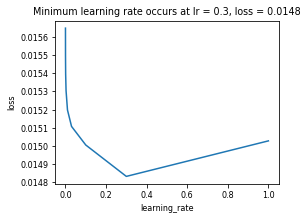

In [164]:
font = {"size": "8"}
plt.figure(figsize = (4,3))
plt.rc("font", **font)
'''
sb.heatmap(assoc_matrix_all, annot = True, fmt = ".2f", \
           linewidth = 0.2,  linecolor = "white")
'''
sb.lineplot(x="learning_rate", y="loss", data=lrs_mod_df)
plt.title(label = "Minimum learning rate occurs at lr = 0.3, loss = 0.0148")
plt.show()

In [165]:
#for lr in lrs:
lr = 0.3
learning_rate = "adaptive"
mlr_imp_lr = MLPRegressor(hidden_layer_sizes = (50, 50), \
                          batch_size = 64, \
                       alpha = 0.001, random_state = 20200116, \
                       max_iter = 2000, solver = "sgd", \
                       learning_rate = learning_rate, 
                          learning_rate_init = lr, \
                         validation_fraction = 0.1)
mlr_imp_lr.n_outputs = 1
mlr_imp_lr.out_activation = "relu"
mlr_imp_lr.fit(X_imp_train, y_imp_train)
#print(mlr_imp_lr.loss)

print("Model lr = {}, loss = {} =" .format(lr, mlr_imp_lr.loss_))   

Model lr = 0.3, loss = 0.014832979546231466 =


In [173]:
np.round(mean_absolute_error(y_imp_test, mlr_imp_lr.predict(X_imp_test)), 3)

0.113

In [172]:
np.round(max_error(y_imp_test, mlr_imp_lr.predict(X_imp_test)), 3)

0.93

In [ ]:
Tuning the learning rate in this case reduces the days until first booking only slightly and might not be necessary in this case.